In [37]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings
import pickle
import tensornetwork as tn
import numpy
np.random = numpy.random
Tensor.np = np
np.random.seed(123458)  # Fix the seed

from jax import numpy as np
from jax import jit, grad

from __future__ import annotations

from typing import Any, Callable

from discopy import Tensor
from discopy.tensor import Diagram

from sympy import default_sort_key, lambdify

from lambeq import BobcatParser
from lambeq.training.model import SizedIterable
from lambeq.training.quantum_model import QuantumModel

In [38]:
# Read data
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

labels, data = read_data('MC1.TXT')
train_targets, train_data = labels[0:15] , data[0:15]
test_targets, test_data = labels[15:100] , data[15:100]


In [39]:
train_data[:10]

['cook creates complicated dish',
 ' experienced chef prepares complicated dish',
 'skilful programmer creates code',
 ' devoted hacker writes code',
 'skilful cook creates meal',
 ' devoted hacker creates complicated code',
 'hacker writes code',
 ' skilful hacker creates code',
 'devoted hacker writes code',
 ' hacker writes complicated code']

In [40]:
train_targets

[[1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1]]

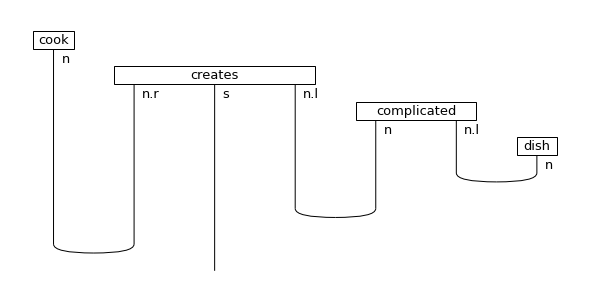

In [41]:
# Parse sentences to diagrams

parser = BobcatParser(verbose='suppress')
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

In [43]:
#Compare diagrams
class BinaryModel(NumpyModel):

    def __init__(self, use_jit: bool = False, **kwargs) -> None:
        super().__init__()
        self.use_jit = use_jit
        self.lambdas: dict[Diagram, Callable] = {}

    def from_diagrams(cls,
                      diagrams: list[Diagram],
                      use_jit: bool = False,
                      **kwargs) -> NumpyModel:

        model = cls(use_jit=use_jit, **kwargs)
        model.symbols = sorted(
            {sym for circ in diagrams for sym in circ.free_symbols},
            key=default_sort_key)
        return model


    def _get_lambda(self, diagram: Diagram) -> Callable[[Any], Any]:

        from jax import jit
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                             '`NumpyModel.from_diagrams()`.')
        if diagram in self.lambdas:
            return self.lambdas[diagram]

        def diagram_output(*x):
            with Tensor.backend('jax'), tn.DefaultBackend('jax'):
                sub_circuit = self._fast_subs([diagram], x)[0]
                result = tn.contractors.auto(*sub_circuit.to_tn()).tensor
                # square amplitudes to get probabilties for pure circuits
                if not sub_circuit.is_mixed:
                    result = Tensor.get_backend().abs(result) ** 2
                return self._normalise_vector(result)

        self.lambdas[diagram] = jit(diagram_output)
        return self.lambdas[diagram]

    def _fast_subs(self,
                   diagrams: list[Diagram],
                   weights: SizedIterable) -> list[Diagram]:
        """Substitute weights into a list of parameterised circuit."""
        parameters = {k: v for k, v in zip(self.symbols, weights)}
        diagrams = pickle.loads(pickle.dumps(diagrams))  # does fast deepcopy
        for diagram in diagrams:
            for b in diagram._boxes:
                if b.free_symbols:
                    while hasattr(b, 'controlled'):
                        b._free_symbols = set()
                        b = b.controlled
                    syms, values = [], []
                    for sym in b._free_symbols:
                        syms.append(sym)
                        try:
                            values.append(parameters[sym])
                        except KeyError:
                            raise KeyError(f'Unknown symbol {sym!r}.')
                    b._data = lambdify(syms, b._data)(*values)
                    b.drawing_name = b.name
                    b._free_symbols = set()
                    if hasattr(b, '_phase'):
                        b._phase = b._data
        return diagrams

    def get_diagram_output(self, diagrams: list[Diagram]) -> numpy.ndarray:
        if len(self.weights) == 0 or not self.symbols:
            raise ValueError('Weights and/or symbols not initialised. '
                             'Instantiate through '
                             '`NumpyModel.from_diagrams()` first, '
                             'then call `initialise_weights()`, or load '
                             'from pre-trained checkpoint.')

        if self.use_jit:
            lambdified_diagrams = [self._get_lambda(d) for d in diagrams]
            return numpy.array([diag_f(*self.weights)
                                for diag_f in lambdified_diagrams])

        diagrams = self._fast_subs(diagrams, self.weights)
        with Tensor.backend('numpy'):
            results = []
            for d in diagrams:
                result = tn.contractors.auto(*d.to_tn()).tensor
                # square amplitudes to get probabilties for pure circuits
                if not d.is_mixed:
                    result = numpy.abs(result) ** 2
                results.append(self._normalise_vector(result))
            return numpy.array(results)

    def forward(self, x: list[Diagram]) -> Any:
        
        return self.get_diagram_output(x)


NameError: name 'NumpyModel' is not defined